In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
#This is James' approximation. w = weight, t=temperature
def eSFR (row):
    w = row['open_weight']
    t = row['degree_days']
    yf = (.2735797591)+(-.0720137809*t)+(.0187408253*t**2)+(-.0008145337*t**3)
    y0 = (-.79303459)+(.43059382*t)+(-.01471246*t**2)
    log_alpha = (-7.8284505676)+(.3748824960*t)+(-.0301640851*t**2)+(.0006516355*t**3)
    return (yf - (yf-y0)*np.exp(-np.exp(log_alpha)*w))

In [3]:
# Function to generate event dates
def generate_event_dates(row):
    event_dates = pd.date_range(row['transfer_date'], row['sw90_date'], freq='D')
    return pd.DataFrame({'locus_id': row['locus_id'],
                         'fish_group_id': row['fish_group_id'],
                         'transfer_year': row['transfer_year'],
                         'event_date': event_dates})

In [5]:
# tgc = pd.read_csv('data/transfers_until2023Feb28_with_sw_growth_targets.csv')
mortality=pd.read_csv('../data/smolt_dataset_transfers.csv') #new/ _until2023May18_short

# sw_growth = pd.read_csv('data\\transfers_with_sw_growth_and_feed_first_90days.csv')
# sw_growth['transfer_date']=pd.to_datetime(sw_growth['transfer_date'])
# sw_growth['transfer_year']=sw_growth['transfer_date'].dt.year

inv=pd.read_csv('../data/evt_inventory_only_SW_cages_only_since_2017.csv') #new/
inv['event_date']=pd.to_datetime(inv['event_date'])

In [7]:
mortality['transfer_date'].max()

'2023-12-11'

In [10]:
inv['event_date'].max()

Timestamp('2023-12-20 00:00:00')

In [11]:
key_columns = ['locus_id','fish_group_id','transfer_year',] 

# df=\
# mortality[key_columns+['to_avg_weight','total_mortality_perc_90','transport_mortality_perc_90','nontransport_mortality_perc_90']].\
# merge(tgc[key_columns+['TGC_SW','SGR_SW','sum_feed_90_kg','avg_weight_90days']]).\
# merge(sw_growth[key_columns+['stocking_count','close_count_90','close_weight_90']],on=key_columns,how='left')
df=mortality[key_columns+['to_avg_weight','total_mortality_perc_90','transport_mortality_perc_90','nontransport_mortality_perc_90']]
df.rename(columns={'to_avg_weight':'stocking_weight'},inplace=True)

In [12]:
df.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'stocking_weight',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90'],
      dtype='object')

In [13]:
# df['biomass_90_kg']=df['close_count_90']*df['avg_weight_90days']/1000
# df['biomass_stocking_kg']=df['stocking_count']*df['stocking_weight']/1000
# df['FCR_SW'] = df['sum_feed_90_kg'] / (df['biomass_90_kg'] - df['biomass_stocking_kg']) 
# df['SFR_SW'] = df['FCR_SW'] * df['SGR_SW']

In [14]:
inv['open_biomass_kg']=inv['open_count']*inv['open_weight']/1000
# inv=inv[inv['open_biomass_kg']>0]
inv['oSFR'] = np.where(inv['open_biomass_kg'] == 0, np.nan, inv['feed_amount'] / inv['open_biomass_kg'] * 100)
inv['eSFR'] = inv.apply(eSFR,axis=1)
inv['nSFR'] = np.where(inv['eSFR'] == 0, np.nan, inv['oSFR'] / inv['eSFR'])

In [16]:
#creating new dataframe with 90 dates for each transfer
tmpp=mortality[key_columns+['transfer_date']]
tmpp['transfer_date']=pd.to_datetime(tmpp['transfer_date'])
tmpp['sw90_date'] = tmpp['transfer_date'] + pd.Timedelta(90,'d')

# Apply the function to each row and concatenate the results
new_df = pd.concat(tmpp.apply(generate_event_dates, axis=1).tolist(), ignore_index=True)

In [17]:
new_df

,locus_id,fish_group_id,transfer_year,event_date
0,3046036,11,2017,2017-01-03
1,3046036,11,2017,2017-01-04
2,3046036,11,2017,2017-01-05
3,3046036,11,2017,2017-01-06
4,3046036,11,2017,2017-01-07
...,...,...,...,...
128123,7205282,6909,2023,2023-09-28
128124,7205282,6909,2023,2023-09-29
128125,7205282,6909,2023,2023-09-30
128126,7205282,6909,2023,2023-10-01


In [18]:
len(new_df)

128128

In [19]:
# len(new_df)

In [20]:
# ttmp=inv[inv.duplicated(subset=['event_date', 'locus_id'], keep=False)]#.oSD
# # ttmp[ttmp.locus_id==3046709]

In [21]:
#check negative nSFR values here
inv_grouped=inv.groupby(['event_date','locus_id'])[['oSFR','eSFR','nSFR']].max().reset_index()
# inv_grouped[inv_grouped.locus_id==7205269]
df_daily = new_df.merge(mortality[key_columns+['transfer_date']]).merge(inv_grouped, how='left')
df_daily['transfer_date']=pd.to_datetime(df_daily['transfer_date'])
#filter out first date of seawater (transfer_date), because of non-typical values of SFR
df_daily=df_daily[df_daily.transfer_date < df_daily.event_date]
df_daily['nSFR'] = np.where(df_daily['eSFR'] < 0, np.nan, df_daily['nSFR'])
df_daily['oSFR'] = df_daily['oSFR'].fillna(0)

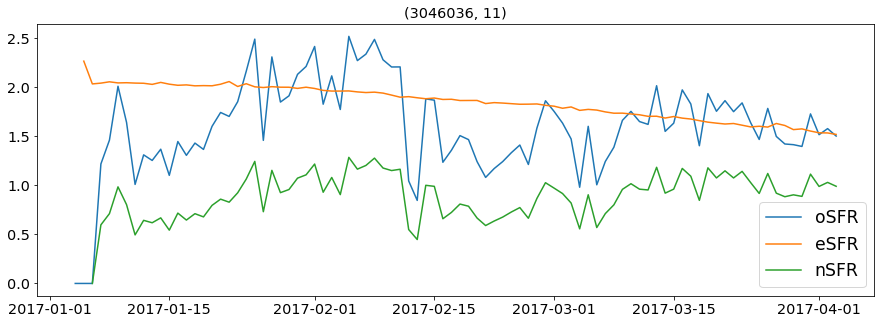

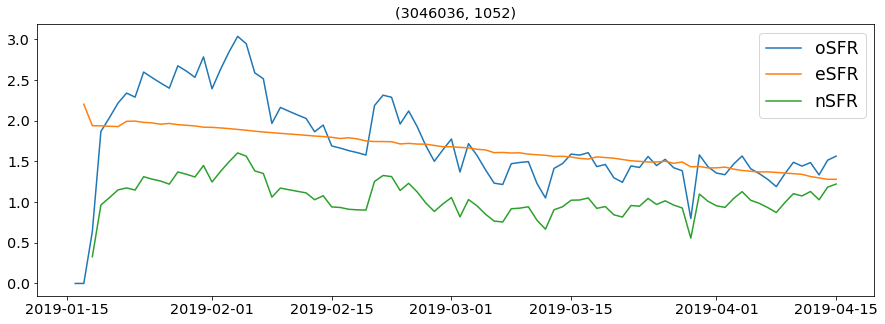

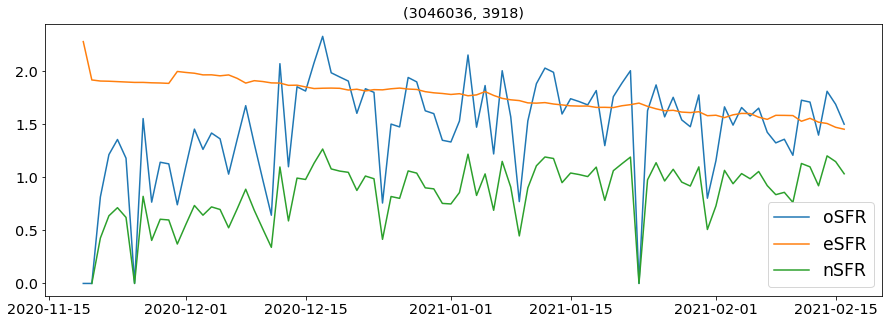

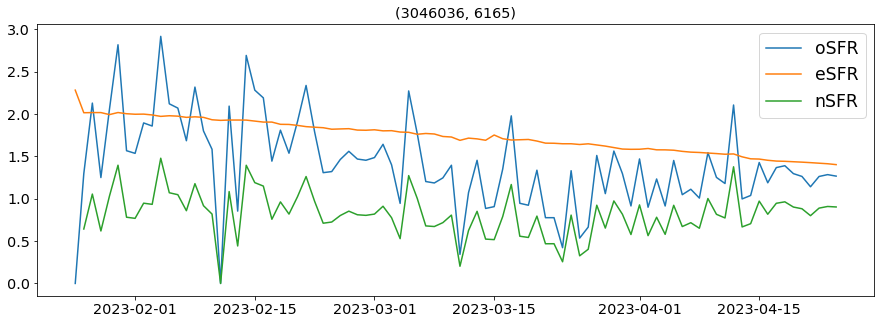

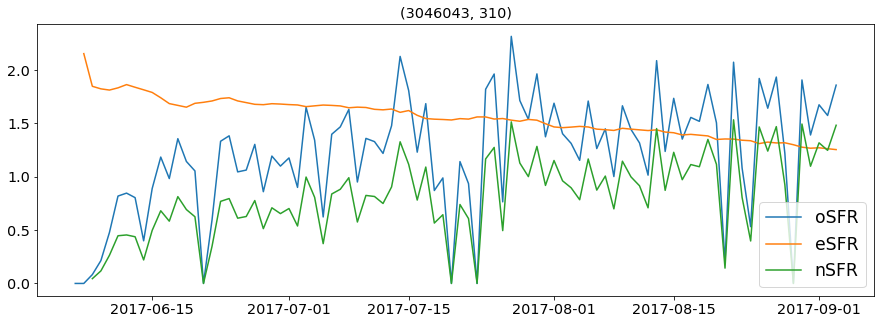

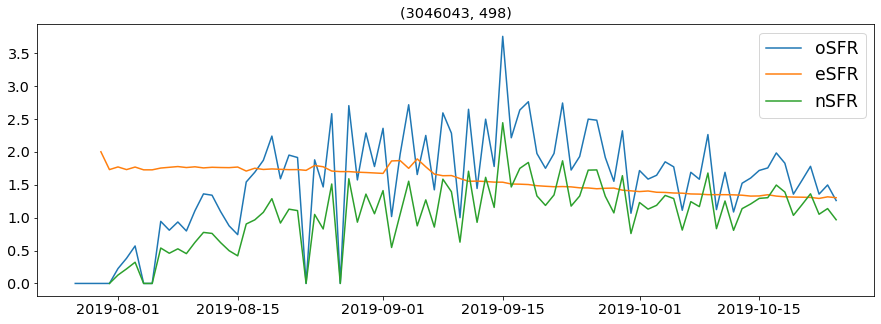

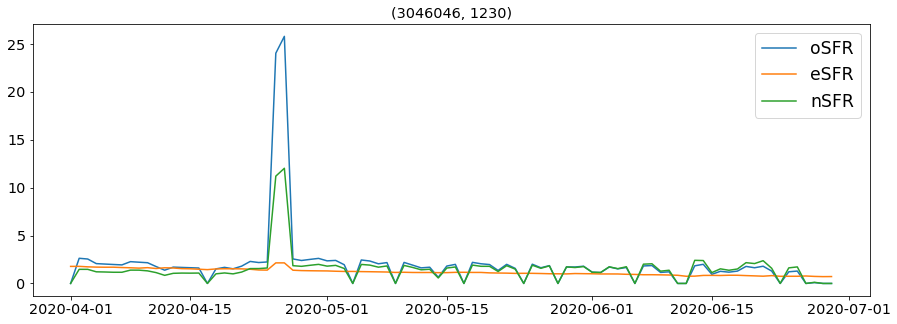

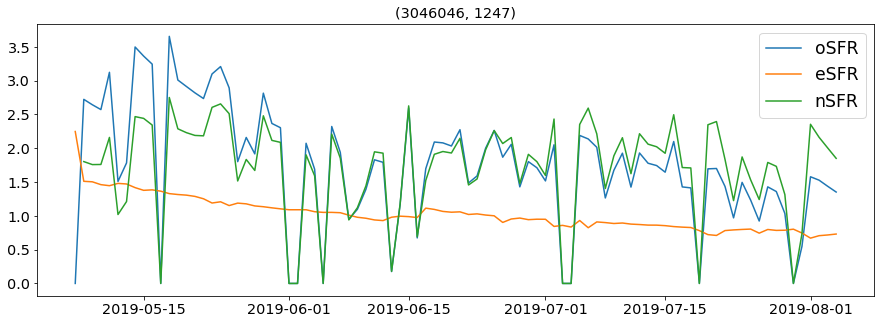

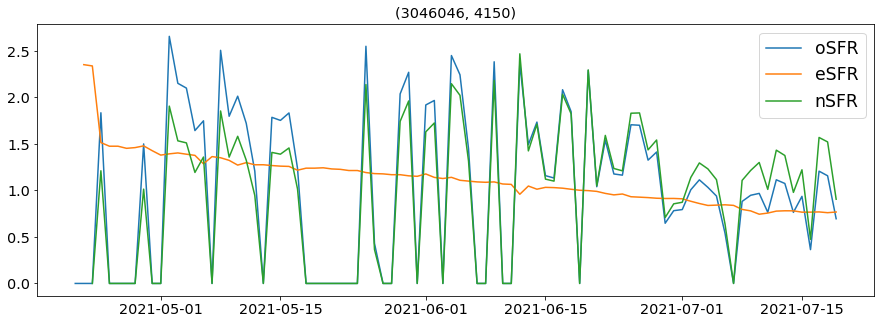

KeyboardInterrupt: 

In [21]:
for ind, curr_df in df_daily.groupby(['locus_id','fish_group_id']):
#     print(ind)
    tmp_daily=curr_df
    
    plt.figure()
    plt.plot(tmp_daily.event_date,tmp_daily.oSFR)
    plt.plot(tmp_daily.event_date,tmp_daily.eSFR)
    plt.plot(tmp_daily.event_date,tmp_daily.nSFR)
    plt.legend(['oSFR', 'eSFR', 'nSFR'])
    plt.title(f'{ind}')
    
    plt.show()
#     plt.savefig("Visualisation\Lineplots\SFR_comparison\\"+str(ind)+'.jpg')


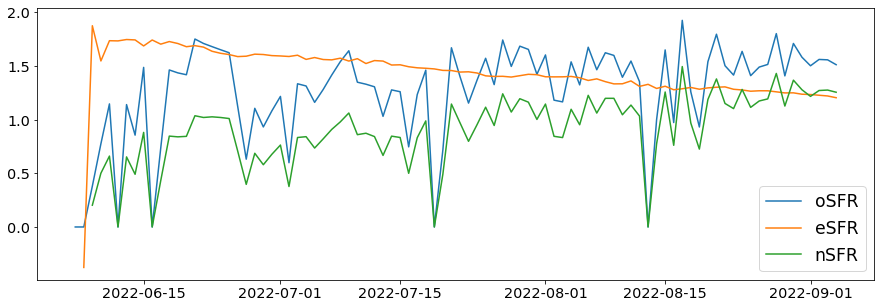

In [22]:
# # tmp_daily=df_daily[(df_daily.locus_id==3046036)&(df_daily.fish_group_id==11)]
# tmp_daily=df_daily[(df_daily.locus_id==7183893)&(df_daily.fish_group_id==6069)]

# plt.plot(tmp_daily.event_date,tmp_daily.oSFR)
# plt.plot(tmp_daily.event_date,tmp_daily.eSFR)
# plt.plot(tmp_daily.event_date,tmp_daily.nSFR)

# plt.legend(['oSFR', 'eSFR', 'nSFR'])

# # plt.savefig('Visualisation\example_of_SFReon.jpg')

In [399]:
# inv[inv.locus_id==7183893].sort_values(by='event_date')

,event_date,locus_id,locus_population_id,open_count,open_weight,close_count,close_weight,degree_days,feed_amount,open_biomass_kg,oSFR,eSFR,nSFR
523258,2022-06-08,7183893,194511900,0,0,45000,146,1.00,0,0.000,NaN,-0.377153,NaN
523632,2022-06-08,7183893,194511904,0,0,0,0,0.00,0,0.000,NaN,-0.793035,NaN
524435,2022-06-08,7183893,194511909,0,0,0,0,0.00,0,0.000,NaN,-0.793035,NaN
523259,2022-06-09,7183893,194511900,45000,146,44185,146,11.10,25,6570.000,0.380518,1.875344,0.202905
523260,2022-06-10,7183893,194511900,44185,146,44185,148,8.60,50,6451.010,0.775072,1.547112,0.500980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
523624,2023-06-09,7183893,194511900,42093,4909,42063,4909,9.85,0,206634.537,0.000000,0.604657,0.000000
523625,2023-06-10,7183893,194511900,42063,4909,42063,4909,9.80,0,206487.267,0.000000,0.601631,0.000000
523626,2023-06-11,7183893,194511900,42063,4909,23955,4937,9.70,0,206487.267,0.000000,0.595503,0.000000
523627,2023-06-12,7183893,194511900,23955,4937,6773,4937,9.61,0,118265.835,0.000000,0.589880,0.000000


In [22]:
df_daily.isna().sum()

locus_id            0
fish_group_id       0
transfer_year       0
event_date          0
transfer_date       0
oSFR                0
eSFR             3856
nSFR             6443
dtype: int64

In [23]:
df_daily[df_daily.nSFR<0]

,locus_id,fish_group_id,transfer_year,event_date,transfer_date,oSFR,eSFR,nSFR
1375,3046100,690,2018,2018-09-22,2018-09-12,1.566676,2.184085,-2.142654
3279,3046179,52,2018,2018-07-06,2018-07-03,0.278293,1.999430,-0.376675
10108,3046497,491,2019,2019-01-31,2019-01-24,0.783203,2.263099,-1.059500
14197,3046645,6179,2023,2023-02-19,2023-02-18,2.087480,2.278448,-3.053950
14294,3046649,324,2018,2018-05-17,2018-05-10,2.498563,2.239410,-3.445341
14653,3046658,939,2017,2017-10-20,2017-10-18,0.572927,2.129890,-0.774621
14934,3046670,218,2018,2018-08-31,2018-08-21,2.796709,2.093841,-3.764807
16021,3046709,1052,2019,2019-01-20,2019-01-15,2.081122,2.203704,-2.822991
16477,3046753,310,2017,2017-06-14,2017-06-08,0.508663,2.141317,-0.694149
17838,3046860,332,2019,2019-02-17,2019-02-15,1.285007,2.313325,-1.771933


In [24]:
df=df.merge(df_daily.groupby(key_columns)[['oSFR','nSFR']].mean().reset_index())

array([[<AxesSubplot:title={'center':'locus_id'}>,
        <AxesSubplot:title={'center':'fish_group_id'}>,
        <AxesSubplot:title={'center':'transfer_year'}>],
       [<AxesSubplot:title={'center':'stocking_weight'}>,
        <AxesSubplot:title={'center':'total_mortality_perc_90'}>,
        <AxesSubplot:title={'center':'transport_mortality_perc_90'}>],
       [<AxesSubplot:title={'center':'nontransport_mortality_perc_90'}>,
        <AxesSubplot:title={'center':'oSFR'}>,
        <AxesSubplot:title={'center':'nSFR'}>]], dtype=object)

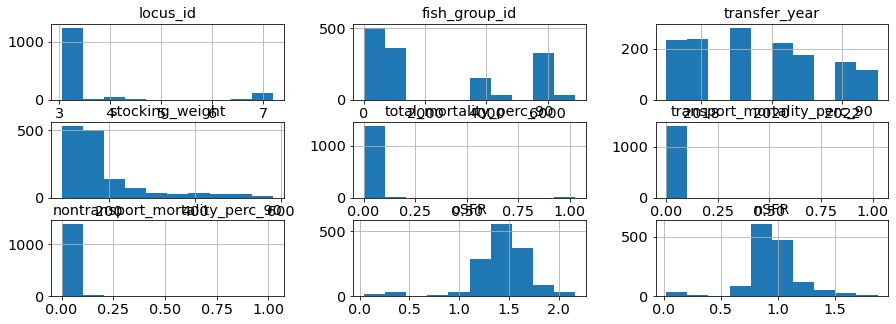

In [17]:
df.hist()

In [412]:
# df_daily.groupby(key_columns)[['oSFR','nSFR']].agg({'mean','median'})

oSFR                nSFR          
                                        median      mean    median      mean
locus_id fish_group_id transfer_year                                        
3046036  11            2017           1.599369  1.591235  0.917553  0.889235
         1052          2019           1.578215  1.735660  1.028447  1.056957
         3918          2020           1.546386  1.461192  0.917187  0.852458
         6165          2023           1.359790  1.413426  0.816472  0.819303
3046043  310           2017           1.307240  1.212387  0.813775  0.823061
...                                        ...       ...       ...       ...
7183889  6071          2022           1.619229  1.469042  1.161332  1.054727
7183890  6072          2022           1.376870  1.285631  1.016064  0.918947
7183891  6072          2022           1.345930  1.232410  0.955441  0.881363
7183892  6069          2022           1.393657  1.272024  0.959249  0.897776
7183893  6069          2022           1.405031  1.266653  0.961123  0.906200

[1262 rows x 4 columns]

In [25]:
# targets=['total_mortality_perc_90', 'transport_mortality_perc_90',
#        'nontransport_mortality_perc_90', 'TGC_SW', 'SGR_SW', 'sum_feed_90_kg','FCR_SW',
#        'SFR_SW', 'oSFR', 'nSFR']
targets=['total_mortality_perc_90',  'TGC_SW', 'SGR_SW', 'sum_feed_90_kg','FCR_SW',
        'oSFR', 'nSFR']
# growth_targets=['TGC_SW', 'SGR_SW', 'sum_feed_90_kg','FCR_SW',
#        'oSFR', 'nSFR']

In [26]:
growth_targets=['oSFR', 'nSFR']

In [27]:
# df.dropna()

Text(0.5, 1.0, 'nSFR')

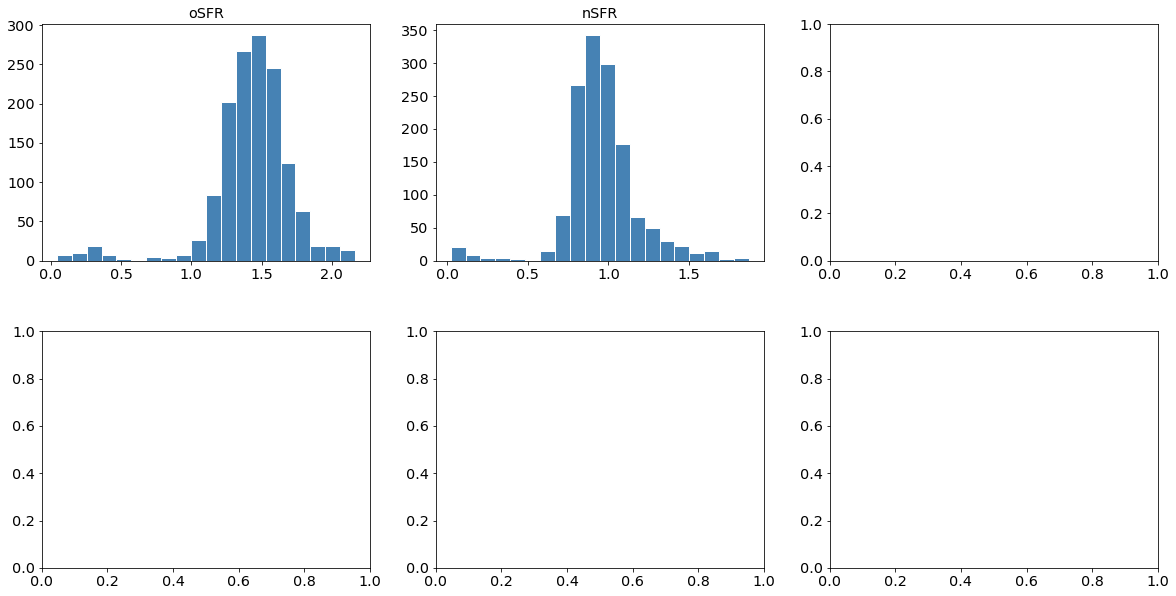

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

tmp_hist = df[growth_targets].dropna()

# Plotting histograms on each subplot
axes[0, 0].hist(tmp_hist[growth_targets[0]], bins=20, color='steelblue', edgecolor='white')
axes[0, 1].hist(tmp_hist[growth_targets[1]], bins=20, color='steelblue', edgecolor='white')
# axes[0, 2].hist(tmp_hist[growth_targets[2]], bins=20, color='steelblue', edgecolor='white')
# axes[1, 0].hist(tmp_hist[growth_targets[3]], bins=20, color='steelblue', edgecolor='white')
# axes[1, 1].hist(tmp_hist[growth_targets[4]], bins=20, color='steelblue', edgecolor='white')
# axes[1, 2].hist(tmp_hist[growth_targets[5]], bins=20, color='steelblue', edgecolor='white')

# Set titles for each subplot
axes[0, 0].set_title(growth_targets[0])
axes[0, 1].set_title(growth_targets[1])
# axes[0, 2].set_title(growth_targets[2])
# axes[1, 0].set_title(growth_targets[3])
# axes[1, 1].set_title(growth_targets[4])
# axes[1, 2].set_title(growth_targets[5])

# plt.savefig('Visualisation\\growth_targets_histograms.png')

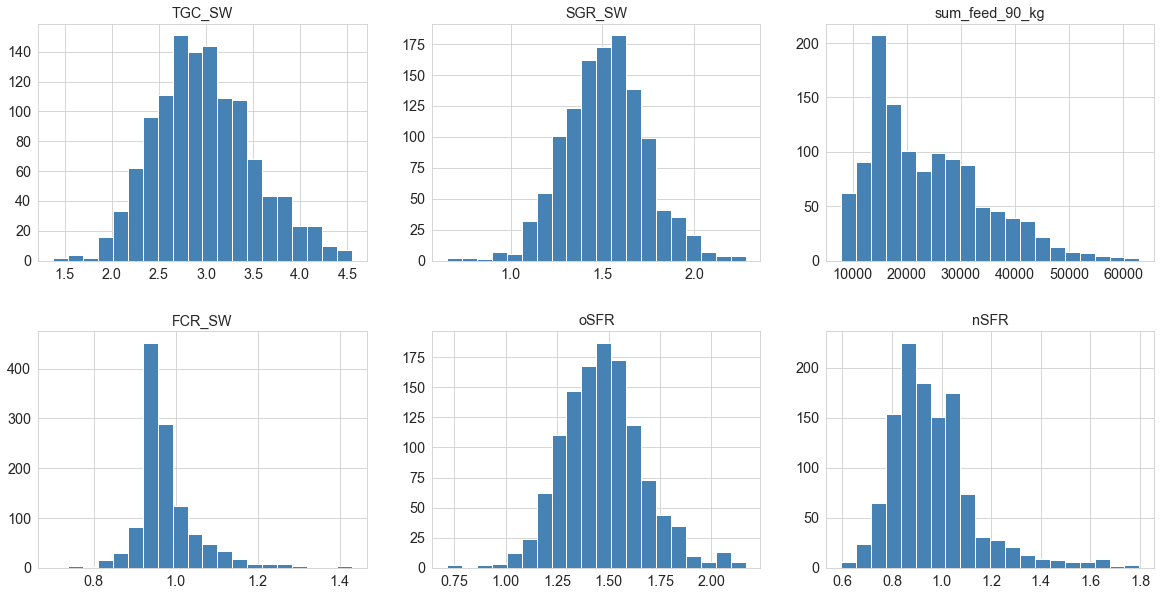

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots

tmp_hist = df[growth_targets].dropna()

# Plotting histograms on each subplot
axes[0, 0].hist(tmp_hist[growth_targets[0]], bins=20, color='steelblue', edgecolor='white')
axes[0, 1].hist(tmp_hist[growth_targets[1]], bins=20, color='steelblue', edgecolor='white')
axes[0, 2].hist(tmp_hist[growth_targets[2]], bins=20, color='steelblue', edgecolor='white')
axes[1, 0].hist(tmp_hist[growth_targets[3]], bins=20, color='steelblue', edgecolor='white')
axes[1, 1].hist(tmp_hist[growth_targets[4]], bins=20, color='steelblue', edgecolor='white')
axes[1, 2].hist(tmp_hist[growth_targets[5]], bins=20, color='steelblue', edgecolor='white')

# Set titles for each subplot
axes[0, 0].set_title(growth_targets[0])
axes[0, 1].set_title(growth_targets[1])
axes[0, 2].set_title(growth_targets[2])
axes[1, 0].set_title(growth_targets[3])
axes[1, 1].set_title(growth_targets[4])
axes[1, 2].set_title(growth_targets[5])

# plt.savefig('Visualisation\\growth_targets_histograms.png')

array([[<AxesSubplot:title={'center':'TGC_SW'}>,
        <AxesSubplot:title={'center':'SGR_SW'}>],
       [<AxesSubplot:title={'center':'sum_feed_90_kg'}>,
        <AxesSubplot:title={'center':'FCR_SW'}>],
       [<AxesSubplot:title={'center':'oSFR'}>,
        <AxesSubplot:title={'center':'nSFR'}>]], dtype=object)

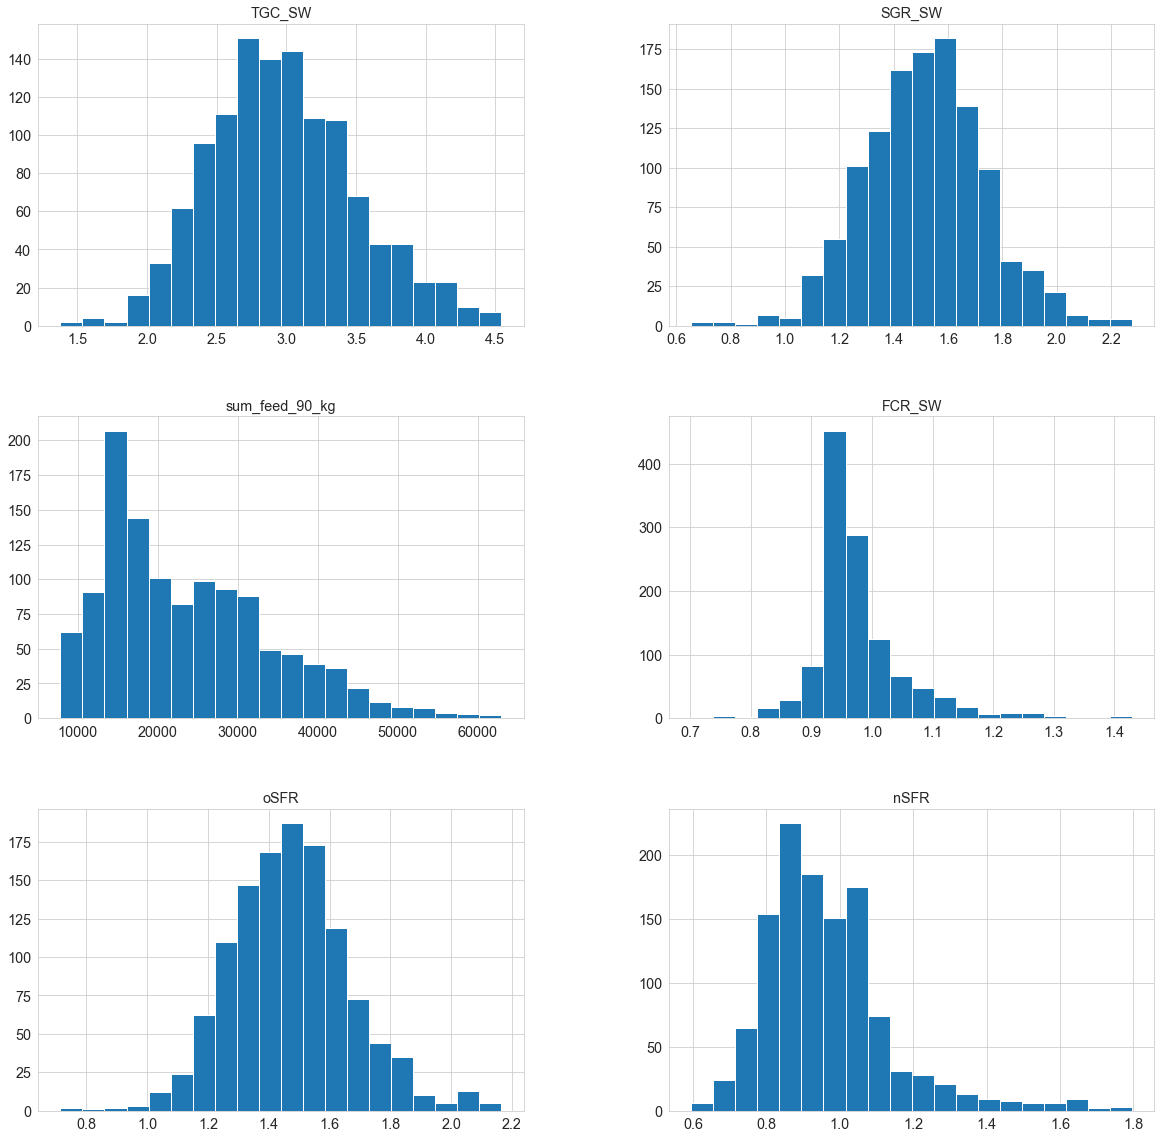

In [93]:
# sns.set_style('whitegrid')
# # df[targets].hist(bins=20, figsize=(20, 20))#, color='steelblue', edgecolor='white')
# df[growth_targets].dropna().hist(bins=20, figsize=(20, 20))#, color='steelblue', edgecolor='white')


In [29]:
#sns.set_style('whitegrid')
df['log_mortality']=np.log(df['total_mortality_perc_90'])
# df[targets].hist(bins=20, figsize=(20, 20))#, color='steelblue', edgecolor='white')
#df[['log_mortality']+targets].dropna().hist(bins=20, figsize=(20, 20))#, color='steelblue', edgecolor='white')
# plt.savefig('Visualisation\\targets_histograms.png')

<AxesSubplot:ylabel='Frequency'>

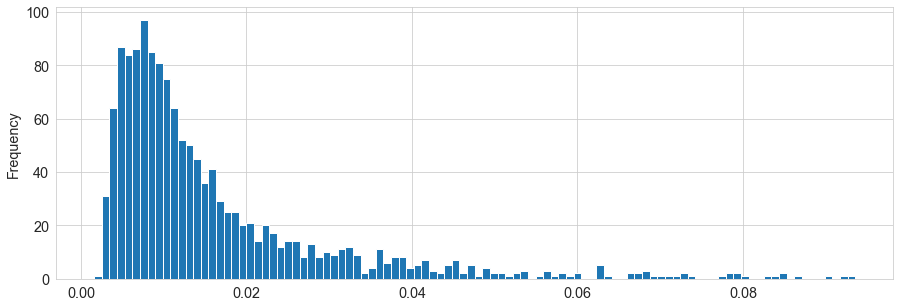

In [33]:
df['total_mortality_perc_90'].plot.hist(bins=100)

<AxesSubplot:>

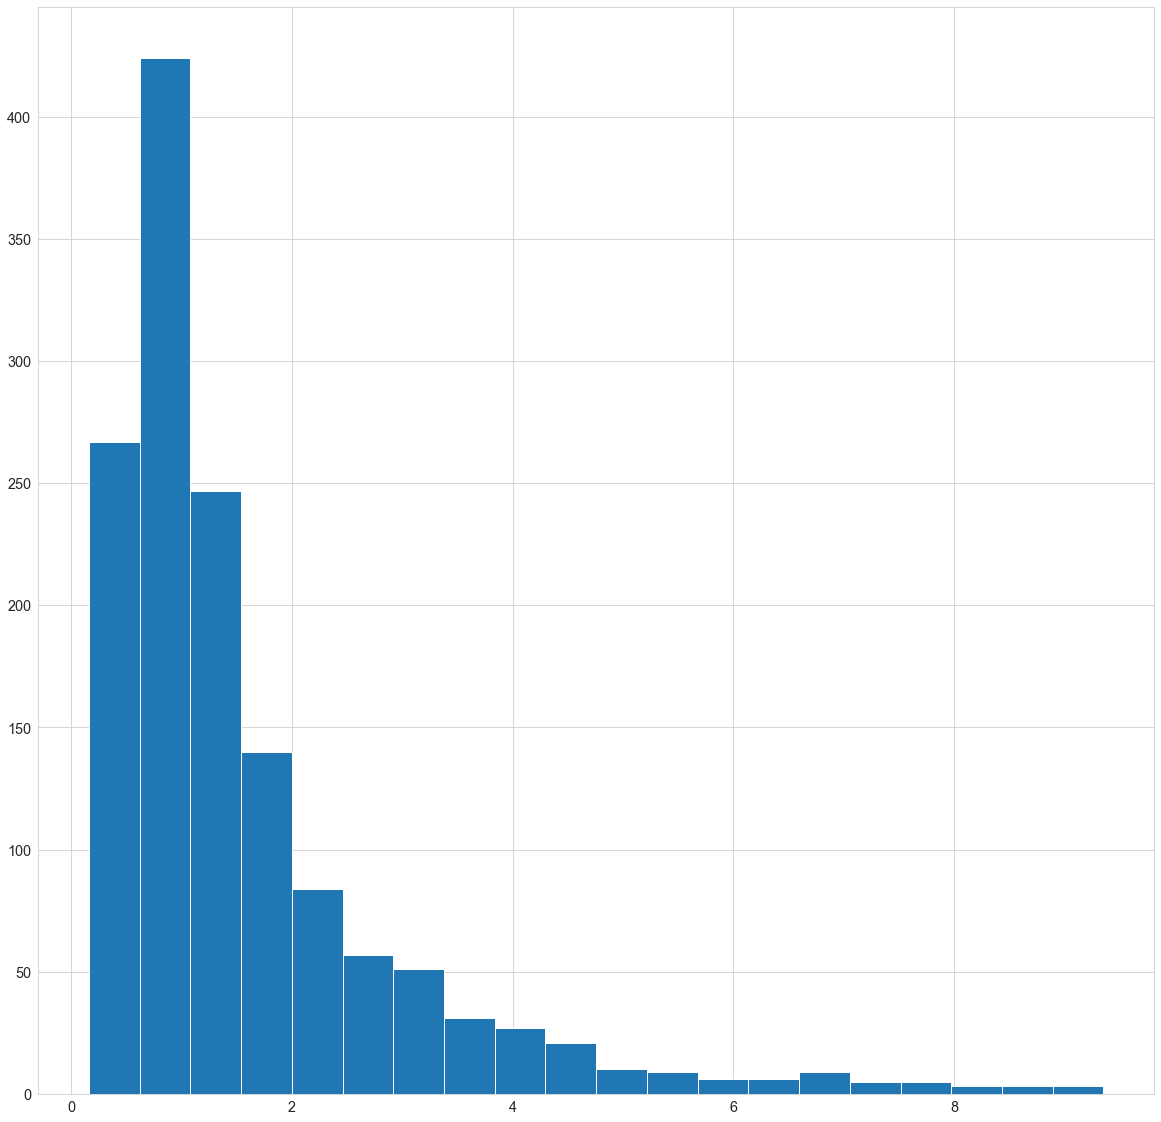

In [34]:
sns.set_style('whitegrid')
# df[targets].hist(bins=20, figsize=(20, 20))#, color='steelblue', edgecolor='white')
(100*df['total_mortality_perc_90']).hist(bins=20, figsize=(20, 20))#, color='steelblue', edgecolor='white')
# plt.savefig('Visualisation\\total_mortality_perc_90_histogram.png')

In [35]:
df[df.nSFR>1.5]

,locus_id,fish_group_id,transfer_year,stocking_weight,total_mortality_perc_90,transport_mortality_perc_90,nontransport_mortality_perc_90,oSFR,nSFR,log_mortality
6,3046046,1230,2020,368,0.006747,0.004361,0.002386,2.034416,1.526953,-4.998625
7,3046046,1247,2019,447,0.007023,0.001949,0.005074,1.735498,1.714637,-4.958631
80,3046340,1247,2019,528,0.015574,0.006530,0.009044,1.599738,1.643166,-4.162137
93,3046422,1205,2019,336,0.005633,0.004257,0.001375,1.773982,1.597096,-5.179126
95,3046439,1247,2019,465,0.008677,0.004267,0.004410,1.676327,1.745464,-4.747083
99,3046448,1247,2019,465,0.007084,0.002986,0.004098,1.758222,1.797136,-4.949982
132,3046551,1230,2020,403,0.007011,0.003916,0.003095,2.055029,1.553223,-4.960297
133,3046551,1247,2019,528,0.013291,0.005919,0.007373,1.515105,1.537456,-4.320648
151,3046636,1230,2020,406,0.007783,0.004300,0.003483,2.140079,1.635598,-4.855782
152,3046636,1247,2019,530,0.024313,0.011245,0.013068,1.460321,1.513490,-3.716736


In [36]:
# Calculate the mean, median, and standard deviation
mean_median_std = df[targets].agg(['mean', 'median', 'std'])

# Calculate the count of NaN values
nan_count = df[targets].apply(lambda x: np.sum(pd.isna(x)), axis=0)

# Calculate the coefficient of variation
cv = mean_median_std.loc['std'] / mean_median_std.loc['mean']

# Combine the results into a new DataFrame
result = pd.DataFrame({'mean': mean_median_std.loc['mean'], 'median': mean_median_std.loc['median'], 'std': mean_median_std.loc['std'], 'nan_count': nan_count, 'cv': cv})

# Print the result
print(result)

result.to_csv('data\stats_on_growth_targets.csv')

KeyError: "['TGC_SW', 'SGR_SW', 'sum_feed_90_kg', 'FCR_SW'] not in index"

In [37]:
df[df.TGC_SW.isna()]

AttributeError: 'DataFrame' object has no attribute 'TGC_SW'

In [38]:
custom_agg

NameError: name 'custom_agg' is not defined

In [40]:
df.to_csv('../data/targets.csv',index=False)

Text(0.5, 1.0, 'Correlation Heatmap')

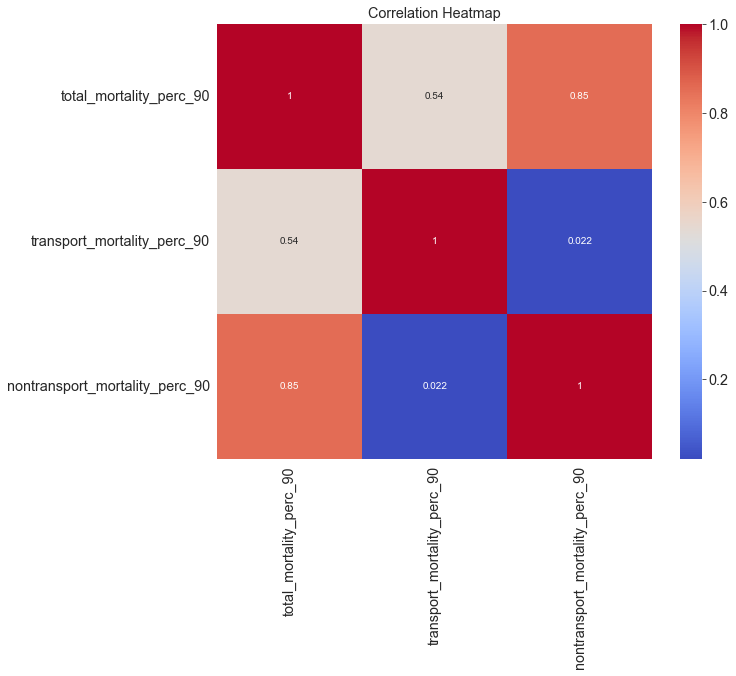

In [42]:
# Calculate the correlation matrix
corr_matrix= df[[x for x in targets if x in ['total_mortality_perc_90','transport_mortality_perc_90','nontransport_mortality_perc_90']]].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

# Set plot title
plt.title('Correlation Heatmap')

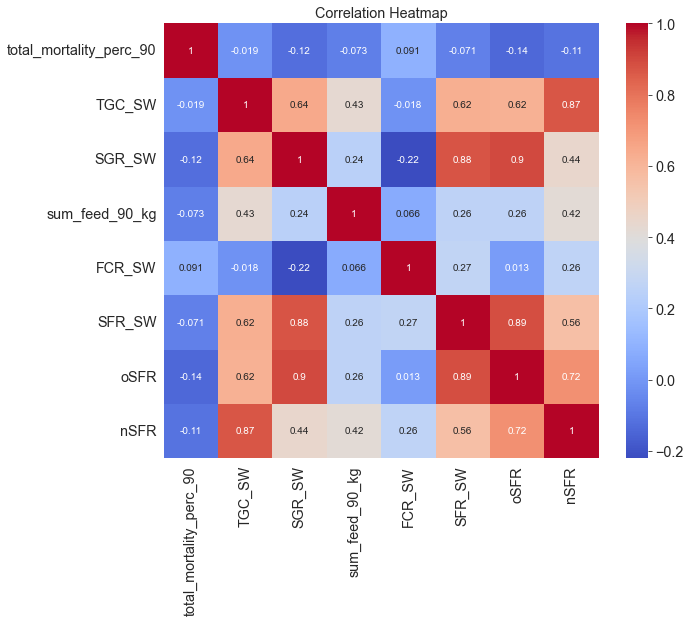

In [44]:
# Calculate the correlation matrix
corr_matrix=df[[x for x in targets if x not in ['transport_mortality_perc_90','nontransport_mortality_perc_90']]].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

# Set plot title
plt.title('Correlation Heatmap')
# plt.savefig('Visualisation\\targets_corr_heatmap.jpg')

In [241]:
inv_clear = inv.copy()
inv_clear=inv_clear[inv_clear['open_biomass_kg']>0]
inv_clear=inv_clear[inv_clear['oSFR']<2.7]
inv_clear=inv_clear[inv_clear.eSFR.between(0,2.7)]
inv_clear=inv_clear[inv_clear['nSFR']<2.7]

In [242]:
print(len(inv),len(inv_clear))

564529 553244


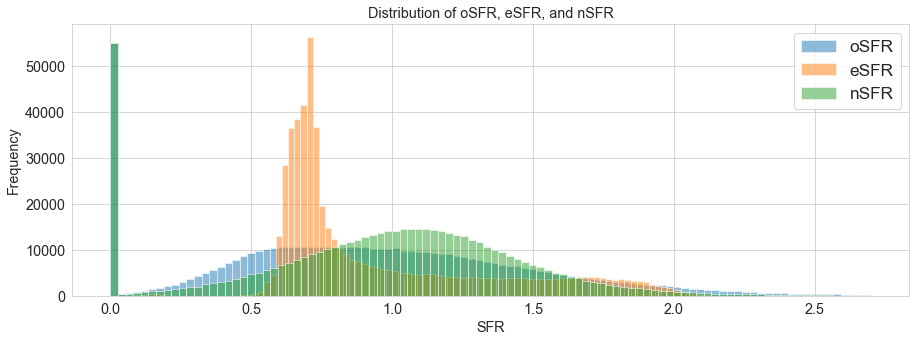

In [244]:
# Plot the histograms
plt.hist(inv_clear['oSFR'], bins=100, label='oSFR', alpha=0.5)
plt.hist(inv_clear['eSFR'], bins=100, label='eSFR', alpha=0.5)
plt.hist(inv_clear['nSFR'], bins=100, label='nSFR', alpha=0.5)

# Add legend
plt.legend()

# Beautify the plot
plt.xlabel('SFR')
plt.ylabel('Frequency')
plt.title('Distribution of oSFR, eSFR, and nSFR')
plt.grid(True)

# plt.savefig('Visualisation\Histograms\SFRoen_full.png')

<AxesSubplot:>

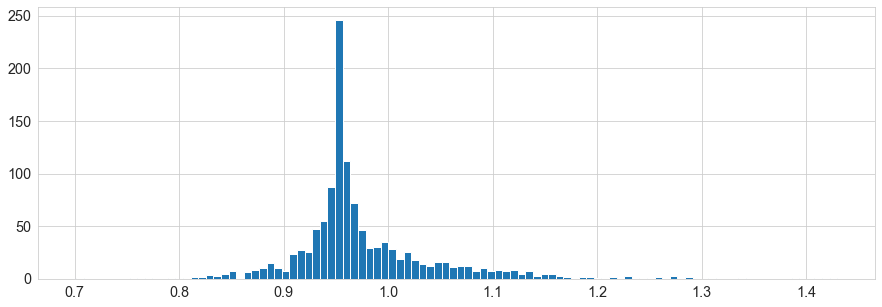

In [116]:
# sns.set_style('whitegrid')
# df['FCR_SW'].hist(bins=100)

<AxesSubplot:>

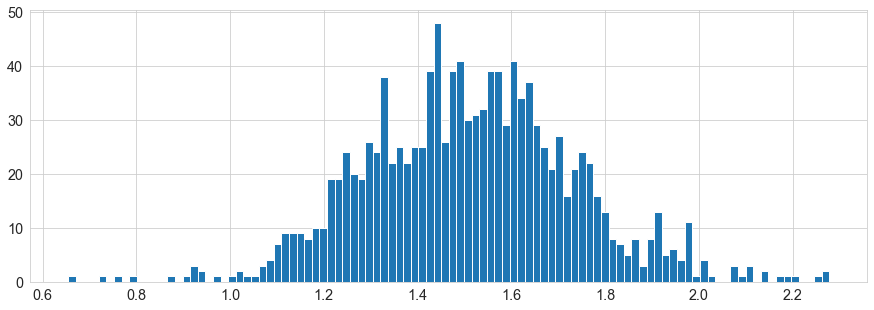

In [118]:
# df.SGR_SW.hist(bins=100)

<AxesSubplot:>

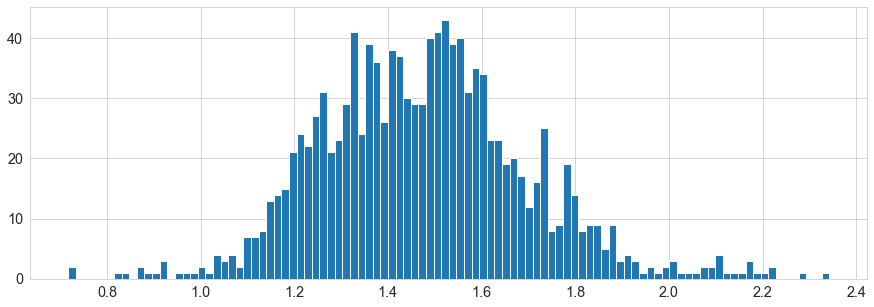

In [121]:
# df['SFR_SW'].hist(bins=100)

<AxesSubplot:>

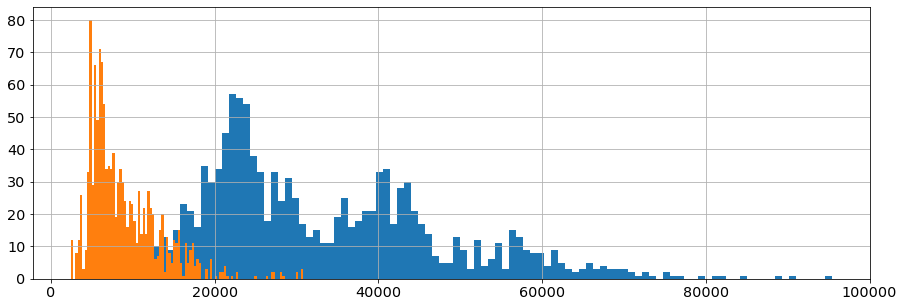

In [107]:
# df['biomass_90_kg'].hist(bins=100)
# df['biomass_stocking_kg'].hist(bins=100)